In [1]:
!pip install prophet
!pip install keras
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install openpyxl

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Function to clean and prepare data for a specific company
def prepare_data(company_data):
    # Remove commas from the Price column
    company_data['Price'] = company_data['Price'].str.replace(',', '')  
    # Extract numerical values from the Price column and convert to float
    company_data['Cleaned_Price'] = company_data['Price'].str.extract('(\d+.\d+)').astype(float)
    # Convert the Date column to datetime format
    company_data['Date'] = pd.to_datetime(company_data['Date'], errors='coerce')
    # Drop rows with missing values in Date or Cleaned_Price columns
    company_data.dropna(subset=['Date', 'Cleaned_Price'], inplace=True)
    return company_data

In [4]:
# Function to calculate and plot EMA, Bollinger Bands, and trading signals
def calculate_indicators_and_signals(company_data):
    # Calculate the 20-day Exponential Moving Average (EMA)
    company_data['EMA_20'] = company_data['Cleaned_Price'].ewm(span=20, adjust=False).mean()
    # Calculate the 20-day rolling standard deviation
    company_data['STD_20'] = company_data['Cleaned_Price'].rolling(window=20).std()
    # Calculate the upper and lower Bollinger Bands
    company_data['Upper_Band'] = company_data['EMA_20'] + (company_data['STD_20'] * 2)
    company_data['Lower_Band'] = company_data['EMA_20'] - (company_data['STD_20'] * 2)
    # Generate trading signals based on Bollinger Bands
    company_data['Signal'] = 'Hold'
    company_data.loc[company_data['Cleaned_Price'] < company_data['Lower_Band'], 'Signal'] = 'Buy'
    company_data.loc[company_data['Cleaned_Price'] > company_data['Upper_Band'], 'Signal'] = 'Sell'
    return company_data

In [5]:
# Function to forecast using Facebook Prophet
def forecast_with_prophet(company_data):
    # Prepare data for Prophet model
    prophet_data = company_data[['Date', 'Cleaned_Price']].rename(columns={'Date': 'ds', 'Cleaned_Price': 'y'})
    model_prophet = Prophet(daily_seasonality=True)
    # Fit the Prophet model
    model_prophet.fit(prophet_data)
    # Create a dataframe for future dates (3 months ahead)
    future = model_prophet.make_future_dataframe(periods=90)
    # Predict future prices
    forecast = model_prophet.predict(future)
    return forecast

In [6]:
# Function to prepare data and train LSTM model
def train_lstm(company_data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Scale the cleaned prices to range (0, 1)
    scaled_data = scaler.fit_transform(company_data['Cleaned_Price'].values.reshape(-1, 1))
    
    # Create dataset for LSTM with a specified time step
    def create_dataset(data, time_step=1):
        X, Y = [], []
        for i in range(len(data) - time_step - 1):
            a = data[i:(i + time_step), 0]
            X.append(a)
            Y.append(data[i + time_step, 0])
        return np.array(X), np.array(Y)
    
    time_step = 10
    X, y = create_dataset(scaled_data, time_step)
    X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM input
    
    # Define and compile the LSTM model
    model_lstm = Sequential()
    model_lstm.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model_lstm.add(LSTM(50))
    model_lstm.add(Dense(1))
    model_lstm.compile(loss='mean_squared_error', optimizer='adam')
    # Train the LSTM model
    model_lstm.fit(X, y, epochs=100, batch_size=1, verbose=2)
    
    # Predict and inverse transform the scaled prices
    train_predict = model_lstm.predict(X)
    train_predict = scaler.inverse_transform(train_predict)
    return train_predict

In [7]:
# Function to calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [8]:
# Function to simulate trading and evaluate capital returns
def simulate_trading(company_data):
    initial_capital = 10000.0  # Starting capital
    capital = initial_capital
    positions = 0  # Number of shares held
    portfolio_values = []

    # Simulate trading based on generated signals
    for index, row in company_data.iterrows():
        if row['Signal'] == 'Buy' and capital > 0:
            positions = capital / row['Cleaned_Price']
            capital = 0
        elif row['Signal'] == 'Sell' and positions > 0:
            capital = positions * row['Cleaned_Price']
            positions = 0
        portfolio_value = capital + (positions * row['Cleaned_Price'])
        portfolio_values.append(portfolio_value)

    final_portfolio_value = portfolio_values[-1]
    total_return = (final_portfolio_value - initial_capital) / initial_capital * 100
    
     # Plot portfolio value over time
    plt.figure(figsize=(14,7))
    plt.plot(company_data['Date'], portfolio_values, label='Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value in $')
    plt.legend()
    plt.show()

    print(f"Total capital return over the period: {total_return:.2f}%")

    return total_return, portfolio_values

In [9]:
# Function to recommend BUY, HOLD, SELL decisions
def recommend_decisions(company_data):
    recommendations = []
    for index, row in company_data.iterrows():
        if row['Signal'] == 'Buy':
            recommendations.append('BUY')
        elif row['Signal'] == 'Sell':
            recommendations.append('SELL')
        else:
            recommendations.append('HOLD')
    company_data['Recommendation'] = recommendations
    return company_data

In [10]:
# URLs for the datasets of the two companies
sheet_urls = {
    'EGYPT, Medinet Nasr Housing (MNHD)': 'https://docs.google.com/spreadsheets/d/1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk/export?format=csv&gid=1827360014',
    'Colombia, Cementos Argos SA (CCB)': 'https://docs.google.com/spreadsheets/d/1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk/export?format=csv&gid=690307818'
}

Analyzing data for: EGYPT, Medinet Nasr Housing (MNHD)


16:16:58 - cmdstanpy - INFO - Chain [1] start processing
16:16:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAPE for EGYPT, Medinet Nasr Housing (MNHD): 21.11%
Epoch 1/100


C:\Users\MSD\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


293/293 - 2s - 6ms/step - loss: 0.0147
Epoch 2/100
293/293 - 0s - 2ms/step - loss: 0.0082
Epoch 3/100
293/293 - 0s - 1ms/step - loss: 0.0073
Epoch 4/100
293/293 - 0s - 1ms/step - loss: 0.0048
Epoch 5/100
293/293 - 0s - 1ms/step - loss: 0.0035
Epoch 6/100
293/293 - 0s - 1ms/step - loss: 0.0033
Epoch 7/100
293/293 - 0s - 1ms/step - loss: 0.0027
Epoch 8/100
293/293 - 0s - 1ms/step - loss: 0.0022
Epoch 9/100
293/293 - 0s - 1ms/step - loss: 0.0021
Epoch 10/100
293/293 - 0s - 1ms/step - loss: 0.0020
Epoch 11/100
293/293 - 0s - 2ms/step - loss: 0.0022
Epoch 12/100
293/293 - 0s - 1ms/step - loss: 0.0017
Epoch 13/100
293/293 - 0s - 1ms/step - loss: 0.0017
Epoch 14/100
293/293 - 0s - 1ms/step - loss: 0.0017
Epoch 15/100
293/293 - 0s - 1ms/step - loss: 0.0014
Epoch 16/100
293/293 - 0s - 1ms/step - loss: 0.0018
Epoch 17/100
293/293 - 0s - 1ms/step - loss: 0.0016
Epoch 18/100
293/293 - 1s - 2ms/step - loss: 0.0018
Epoch 19/100
293/293 - 0s - 1ms/step - loss: 0.0017
Epoch 20/100
293/293 - 0s - 1ms/s

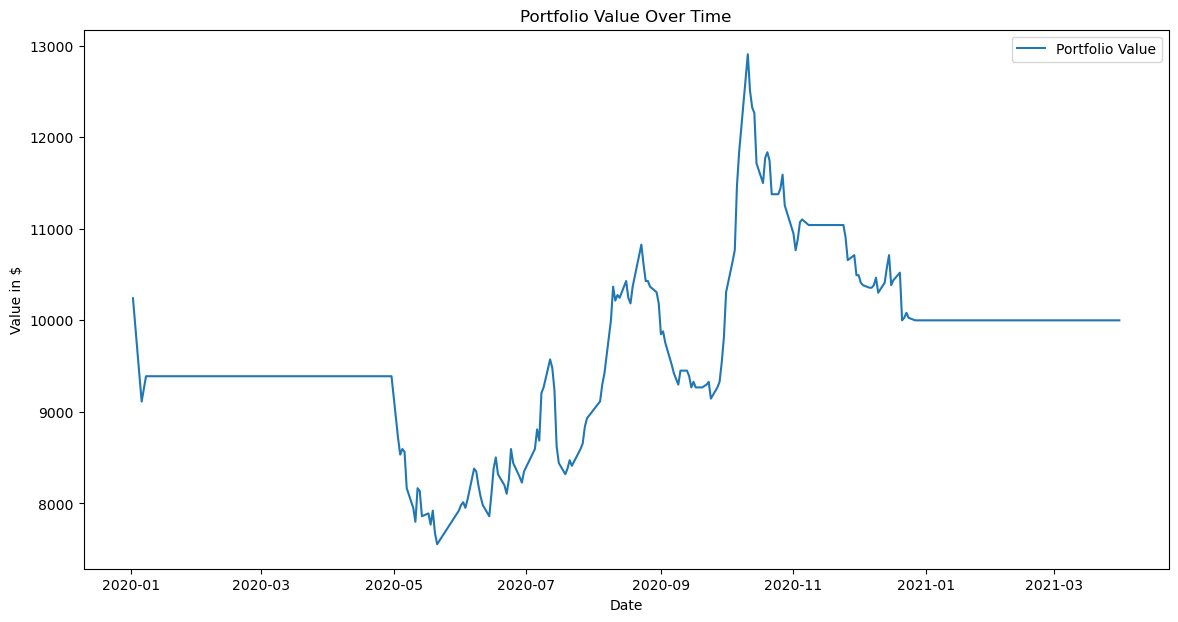

Total capital return over the period: 2.41%
        Date  Cleaned_Price Recommendation
0 2021-03-31           3.75           HOLD
1 2021-03-30           3.73           HOLD
2 2021-03-29           3.70           HOLD
3 2021-03-28           3.71           HOLD
4 2021-03-25           3.71           HOLD
Analyzing data for: Colombia, Cementos Argos SA (CCB)


16:17:45 - cmdstanpy - INFO - Chain [1] start processing
16:17:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAPE for Colombia, Cementos Argos SA (CCB): 25.63%
Epoch 1/100


C:\Users\MSD\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


292/292 - 2s - 6ms/step - loss: 0.0140
Epoch 2/100
292/292 - 0s - 1ms/step - loss: 0.0066
Epoch 3/100
292/292 - 0s - 1ms/step - loss: 0.0052
Epoch 4/100
292/292 - 0s - 1ms/step - loss: 0.0045
Epoch 5/100
292/292 - 0s - 1ms/step - loss: 0.0039
Epoch 6/100
292/292 - 0s - 1ms/step - loss: 0.0031
Epoch 7/100
292/292 - 0s - 1ms/step - loss: 0.0024
Epoch 8/100
292/292 - 0s - 1ms/step - loss: 0.0021
Epoch 9/100
292/292 - 0s - 1ms/step - loss: 0.0017
Epoch 10/100
292/292 - 0s - 1ms/step - loss: 0.0016
Epoch 11/100
292/292 - 0s - 1ms/step - loss: 0.0015
Epoch 12/100
292/292 - 0s - 1ms/step - loss: 0.0016
Epoch 13/100
292/292 - 0s - 1ms/step - loss: 0.0014
Epoch 14/100
292/292 - 0s - 1ms/step - loss: 0.0017
Epoch 15/100
292/292 - 0s - 1ms/step - loss: 0.0013
Epoch 16/100
292/292 - 0s - 1ms/step - loss: 0.0014
Epoch 17/100
292/292 - 0s - 1ms/step - loss: 0.0013
Epoch 18/100
292/292 - 0s - 1ms/step - loss: 0.0012
Epoch 19/100
292/292 - 0s - 1ms/step - loss: 0.0013
Epoch 20/100
292/292 - 0s - 1ms/s

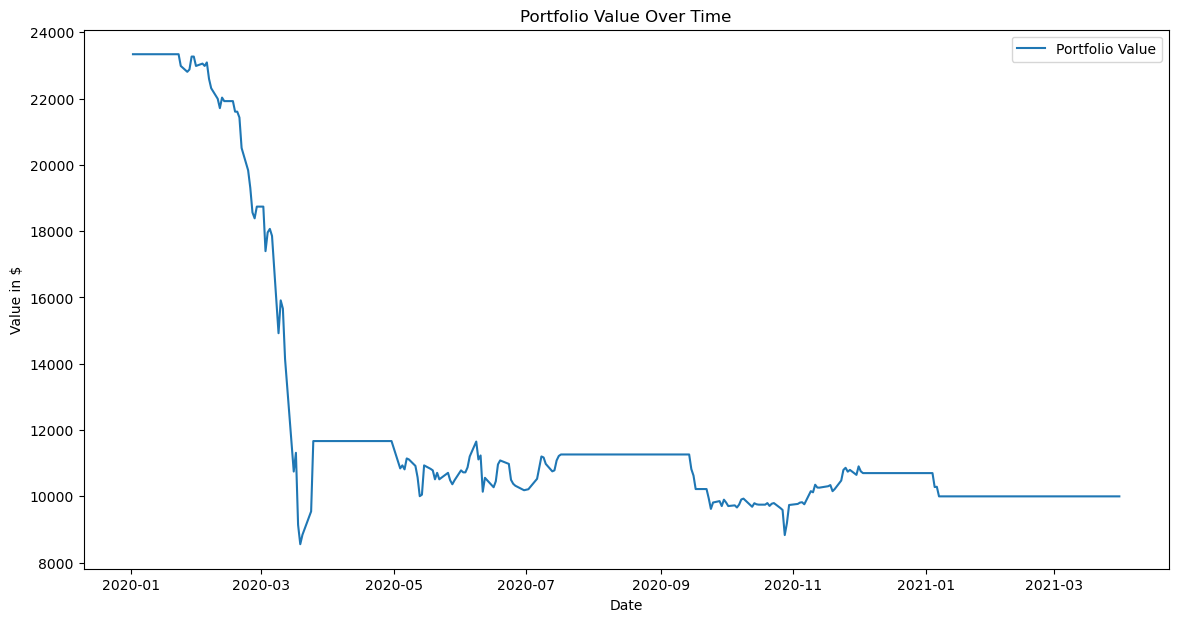

Total capital return over the period: 133.36%
        Date  Cleaned_Price Recommendation
0 2021-03-31         5150.0           HOLD
1 2021-03-30         5100.0           HOLD
2 2021-03-29         5045.0           HOLD
3 2021-03-26         5020.0           HOLD
4 2021-03-25         5030.0           HOLD


In [20]:
# Main analysis loop for each company
for sheet_name, sheet_url in sheet_urls.items():
    print(f"Analyzing data for: {sheet_name}")
    
    # Load the company's data
    company_data = pd.read_csv(sheet_url)
    # Prepare the data
    company_data = prepare_data(company_data)
    
    # Calculate indicators and generate signals
    company_data = calculate_indicators_and_signals(company_data)
    
    # Forecast with Prophet and calculate MAPE
    forecast = forecast_with_prophet(company_data)
    prophet_mape = calculate_mape(company_data['Cleaned_Price'], forecast['yhat'][:len(company_data)])
    print(f"Prophet MAPE for {sheet_name}: {prophet_mape:.2f}%")
    
    # Train LSTM and calculate MAPE
    train_predict = train_lstm(company_data)
    lstm_mape = calculate_mape(company_data['Cleaned_Price'][10:len(train_predict)+10], train_predict.flatten())
    print(f"LSTM MAPE for {sheet_name}: {lstm_mape:.2f}%")
    
    # Simulate trading and evaluate capital returns
    total_return, portfolio_values = simulate_trading(company_data)

    # Generate recommendations
    company_data = recommend_decisions(company_data)
    print(company_data[['Date', 'Cleaned_Price', 'Recommendation']].head())

    # Save the recommendations to a CSV file
    company_data.to_csv(f'{sheet_name}_recommendations.csv', index=False)

# Analysis Summary

## EGYPT, Medinet Nasr Housing (MNHD)
- **Prophet MAPE**: 21.11%
- **LSTM MAPE**: 1.68%
- **Total Capital Return**: 2.41%

## Colombia, Cementos Argos SA (CCB)
- **Prophet MAPE**: 25.63%
- **LSTM MAPE**: 2.08%
- **Total Capital Return**: 133.36%